In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow.examples.tutorials.mnist.input_data as input_data

import os
import glob

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
X = mnist.train.images
y = mnist.train.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### Plot of Input Data with Noise

In [3]:
def plot_input(rvae_generated,noise_factor):
    h = w = 28
    num_gen = 100

    n = np.sqrt(num_gen).astype(np.int32)
    I_generated = np.empty((h*n, w*n))
    for i in range(n):
        for j in range(n):
            I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = rvae_generated[i*n+j, :].reshape(28, 28)

    plt.figure(figsize=(8, 8))
    plt.title("Examples of Input with Noise Facotr "+str(noise_factor))
    plt.imshow(I_generated, cmap='gray')
    plt.show()

### Load Latent Data

In [4]:
models = ['RDA','RPCA','RVAE'] 
noise_factors = [0.0,0.2,0.4]

In [5]:
transformed_data = {}
for model in models:
    path = 'withPCA/'+model+'/*'
    file_list = glob.glob(path)
    tmp = {}
    for i in range(len(file_list)):
        tmp[noise_factors[i]]=np.load(file_list[i])
    transformed_data[model]=tmp

In [6]:
pca_latent = {}
original_input = {}
for noise_factor in noise_factors:
    x_train_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
#     plot_input(x_train_noisy,noise_factor)
    pca = PCA(n_components=2)
#     pca.fit(x_train_noisy)
    pca_transform = pca.fit_transform(x_train_noisy)
    pca_latent[noise_factor] = pca_transform
    original_input[noise_factor] = x_train_noisy

In [7]:
models.append('PCA')
transformed_data['PCA'] = pca_latent

models.append('Original')
transformed_data['Original'] = original_input

### Test Dimension Reduction with Random Forest

In [8]:
def test_denoising_acc(X):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    
    clf = RandomForestClassifier(n_estimators=50, max_depth=2, random_state=595)
    clf.fit(X_train, y_train)
    
    return clf.score(X_test, y_test)

In [9]:
models_acc = {}
for i in range(len(models)):
    tmp = {}
    for j in range(len(noise_factors)):
        test_acc = test_denoising_acc(transformed_data[models[i]][noise_factors[j]])
        tmp[noise_factors[j]] = test_acc
    models_acc[models[i]] = tmp

In [10]:
df_model_acc = pd.DataFrame.from_dict(models_acc)
df_model_acc

,RDA,RPCA,RVAE,PCA,Original
0.0,0.470618,0.622545,0.301164,0.384873,0.634836
0.2,0.679709,0.609527,0.298764,0.383418,0.568509
0.4,0.577745,0.596291,0.212727,0.372218,0.500800


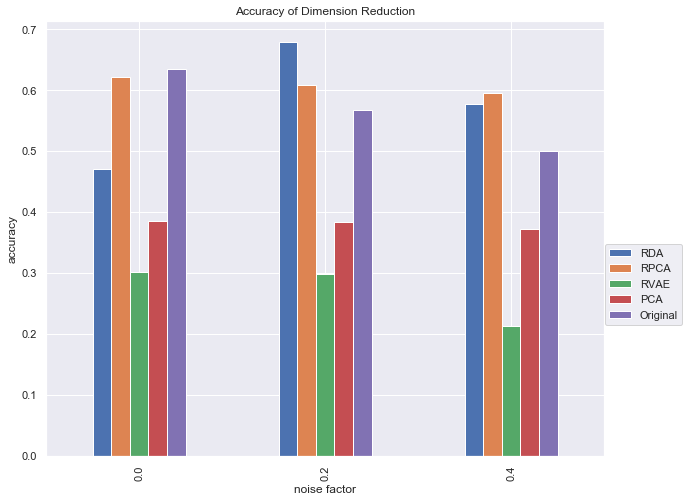

In [11]:
ax = df_model_acc.plot(figsize=(10,8),kind = 'bar')
ax.legend(bbox_to_anchor=(1.15, 0.5))
plt.title('Accuracy of Dimension Reduction')
plt.xlabel('noise factor')
plt.ylabel('accuracy')
plt.show()